In [1]:
!pip3 install torch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os

import string

all_letters = string.ascii_letters + " .,'"
n_letters = len(all_letters)

# Build the category_lines dictionary
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [line for line in lines]

files = ['sample_data/male.txt', 'sample_data/female.txt']


all_categories.append("male")
maleNames = readLines(files[0])
category_lines["male"] = maleNames

all_categories.append("female")
femaleNames = readLines(files[1])
category_lines["female"] = femaleNames

n_categories = len(all_categories)

In [9]:
print(category_lines['male'][:5])

['surjeet', 'harender', 'parveen', 'raja', 'veer']


In [10]:
import torch

def letterToIndex(letter):
    return all_letters.find(letter)

def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor


In [11]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [16]:
input = lineToTensor('Samiksha')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-0.6921, -0.6942]], grad_fn=<LogSoftmaxBackward0>)


In [17]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('male', 0)


In [18]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = male / line = parveen
category = male / line = nadim
category = male / line = damanjeet
category = male / line = nirmal
category = female / line = santna
category = female / line = meenakshi
category = female / line = ramaiya
category = male / line = mustafa
category = female / line = tapsya
category = female / line = vivek


In [19]:
criterion = nn.NLLLoss()

In [20]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

In [21]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000


# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 5s) 0.2255 shisupal / male ✓
10000 10% (0m 11s) 0.0905 alka / female ✓
15000 15% (0m 16s) 0.1364 har / male ✓
20000 20% (0m 21s) 1.4250 krishana / female ✗ (male)
25000 25% (0m 27s) 0.2430 uttam / male ✓
30000 30% (0m 32s) 0.2773 sazi / female ✓
35000 35% (0m 38s) 0.1012 amit / male ✓
40000 40% (0m 43s) 0.0246 somender / male ✓
45000 45% (0m 49s) 0.0470 amardeep / male ✓
50000 50% (0m 54s) 0.0229 marjina / female ✓
55000 55% (1m 0s) 0.0287 yuvraj / male ✓
60000 60% (1m 5s) 0.2041 mamuni / female ✓
65000 65% (1m 11s) 0.3528 rimpy / female ✓
70000 70% (1m 16s) 0.1622 firida / female ✓
75000 75% (1m 22s) 0.1355 roshini / female ✓
80000 80% (1m 27s) 0.0698 kamni / female ✓
85000 85% (1m 33s) 0.2591 saraswati / female ✓
90000 90% (1m 39s) 0.5709 shehnaz / female ✓
95000 95% (1m 45s) 0.0434 ravina / female ✓
100000 100% (1m 50s) 1.4482 ramchander / female ✗ (male)


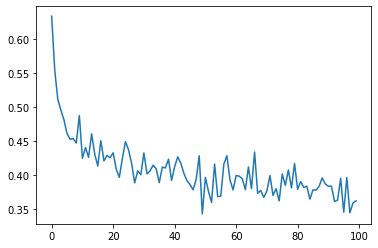

In [22]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

In [25]:
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

In [26]:
def predict(input_line, n_predictions=2):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get all results
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

In [27]:
predict('Devbrat')


> Devbrat
(-0.03) male
(-3.57) female


In [28]:
predict('Mandakini')


> Mandakini
(-0.08) female
(-2.55) male
